# Setup

In [190]:
# Import libraries used in this notebook
import os
import cv2
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torchvision.transforms as transforms
from PIL import Image


In [1]:
# Set File path for Image Data
data_filepath = './data/chest_xray'

# Image EDA

In [42]:
# Create a Dataframe of image paths and their corresponding Label (Normal, Pnemonia)

# Use the TRAIN and TEST directories to build Dataframe
image_dirs = ['train', 'test']
data = []

# Loop through Image Directories to find images
for dir in image_dirs:
    dir_path = os.path.join(data_filepath, dir)
    # Loop through NORMAL and PNEUMONIA directories, and label images accordingly
    for label_name in ["NORMAL", "PNEUMONIA"]:
        label_dir = os.path.join(dir_path, label_name)
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            # Ensure it's an image file (basic check)
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                data.append([file_path, label_name])

    
# Create DataFrame
df = pd.DataFrame(data, columns=["image_path", "label"])
df

image_path      label
0      ./data/chest_xray\train\NORMAL\IM-0115-0001.jpeg     NORMAL
1      ./data/chest_xray\train\NORMAL\IM-0117-0001.jpeg     NORMAL
2      ./data/chest_xray\train\NORMAL\IM-0119-0001.jpeg     NORMAL
3      ./data/chest_xray\train\NORMAL\IM-0122-0001.jpeg     NORMAL
4      ./data/chest_xray\train\NORMAL\IM-0125-0001.jpeg     NORMAL
...                                                 ...        ...
5835  ./data/chest_xray\test\PNEUMONIA\person96_bact...  PNEUMONIA
5836  ./data/chest_xray\test\PNEUMONIA\person96_bact...  PNEUMONIA
5837  ./data/chest_xray\test\PNEUMONIA\person97_bact...  PNEUMONIA
5838  ./data/chest_xray\test\PNEUMONIA\person99_bact...  PNEUMONIA
5839  ./data/chest_xray\test\PNEUMONIA\person99_bact...  PNEUMONIA

[5840 rows x 2 columns]

## Class Distribution

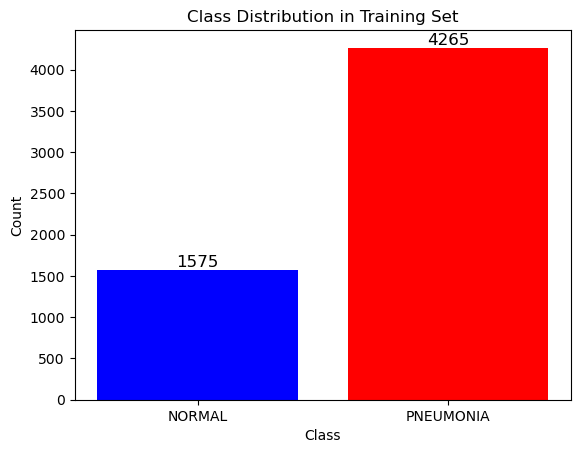

In [192]:
# List of Normal and Pneumonia Images
normal_imgs = df[df['label'] == 'NORMAL']['image_path']
pneumonia_imgs =  df[df['label'] == 'PNEUMONIA']['image_path']

# Count the number of images in each class
label_counts = pd.Series({
    "NORMAL": len(normal_imgs),
    "PNEUMONIA": len(pneumonia_imgs)
})

# Create bar plot
fig, ax = plt.subplots()
bars = ax.bar(label_counts.index, label_counts.values, color=["blue", "red"])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}", ha='center', va='bottom', fontsize=12)

# Labels and title
ax.set_title("Class Distribution in Training Set")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

plt.show()


## Image Viewing

The above barchart shows the class breakdown for TRAIN and TEST X-Ray data across the 2 classes.  There is a large class imbalance between PNEUMONIA and NORMAL images, with PNEUMONIA being the dominant at almost 3 to 1.  This will likely have several impacts on model performance including overfitting on the majority class,underperforming on the NORMAL class (High Accuracy but low Recall), and poor generalization to real-world data.

Several options exist to address this imbalance including Oversampling, Undersampling, Data Augmentation, or adjusting class weights or the loss function used by the model.

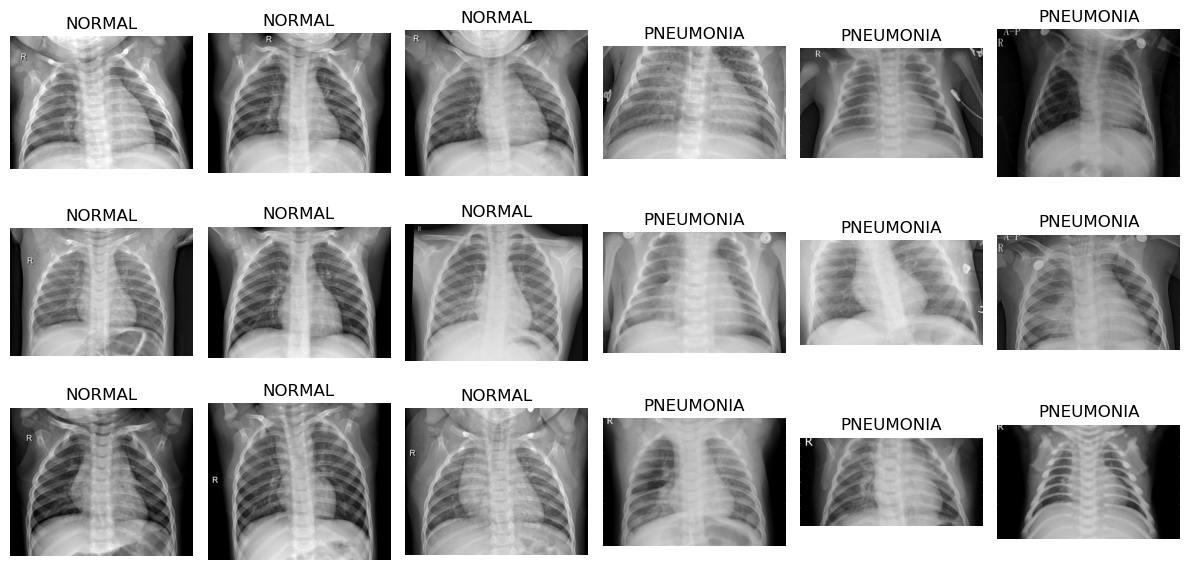

In [124]:

def compare_imgs(imgs_list_1, imgs_list_2, label_1, label_2):
    '''Function to Compare 2 sets of images'''
    # Create a 3x6 plot
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 6))
    
    # Plot images
    for i in range(sample_size):
        # Load images
        img_1 = cv2.imread(imgs_list_1.iloc[i], cv2.IMREAD_GRAYSCALE)
        img_2 = cv2.imread(imgs_list_2.iloc[i], cv2.IMREAD_GRAYSCALE)
        
        # NORMAL images (First 3 columns)
        axes[i // 3, i % 3].imshow(img_1, cmap="gray")
        axes[i // 3, i % 3].set_title(label_1)
    
        # PNEUMONIA images (Next 3 columns)
        axes[i // 3, i % 3 + 3].imshow(img_2, cmap="gray")
        axes[i // 3, i % 3 + 3].set_title(label_2)
    
    # Remove axes
    for ax in axes.flat:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


# Select a sample of NORMAL and PNEUMONIA images 
sample_size = 9
normal_sample = df[df['label'] == 'NORMAL']['image_path'].sample(n=sample_size)
pneumonia_sample =  df[df['label'] == 'PNEUMONIA']['image_path'].sample(n=sample_size)

# Compare NORMAL images to PNEUMONIA images
compare_imgs(normal_sample, pneumonia_sample, "NORMAL", "PNEUMONIA")

The dataset consists of grayscale chest X-ray images of patients in various positions. A simple visual analysis reveals some important details:  
- The visual differences between "NORMAL" and "PNEUMONIA" cases are subtle and not immediately apparent to the naked eye. However, in general, pneumonia cases tend to exhibit increased occlusion in the chest cavity due to fluid accumulation or lung consolidation.

- The images are not uniform in size or resolution. Some images appear larger and more zoomed in, while others capture a wider field of view. Standardizing image dimensions will be necessary for consistent model training.

- The dataset includes images of patients in different postures, such as arms above the head, arms at the side, and slight body rotation. These variations could introduce inconsistencies in model learning if training data is small.  Having more training data with rotated images, or different image positions can correct this difference.

- Some images, particularly those labeled as "PNEUMONIA", contain visual artifacts such as wires, medical devices, and other obstructions. These elements could potentially impact model performance.
  
  
To improve the quality of the dataset and extract more meaningful insights for classification, the following additional investigations should be considered:  
- Due to variations in image sizes, implement a preprocessing pipeline to scale all images to a standard resolution. Cropping or padding techniques may also be explored to maintain anatomical integrity.

- Analyze pixel intensity distributions across images to identify potential outliers or inconsistencies, as well as find patterns across the two categories.

- Experiment with various image visualization techniques such as:  
  - Ben Graham's preprocessing method (designed for medical imaging).
  - Background subtraction to highlight critical lung structures.
  - Sobel filtering or colormaps to enhance edge detection and contrast.
  - Utilize t-SNE or PCA to visualize the distribution of NORMAL vs. PNEUMONIA cases in a lower-dimensional space, which may reveal underlying patterns that aid classification.

## Comparing Image Dimensions

In [73]:
# Add Height and Width dimensions of the images to the dataframe

def get_dimensions(img_file):
    """Returns the width and height of an image file."""
    with Image.open(img_file) as img:
        width, height = img.size  # Unpack width and height
        return width, height

# Assume df contains a column 'image_path' with file paths
df['width'], df['height'] = zip(*df['image_path'].apply(get_dimensions))
df[['width', 'height']].describe()

width       height
count  5840.000000  5840.000000
mean   1327.825000   970.600685
std     363.764314   383.681911
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1281.000000   886.000000
75%    1560.000000  1187.000000
max    2916.000000  2713.000000

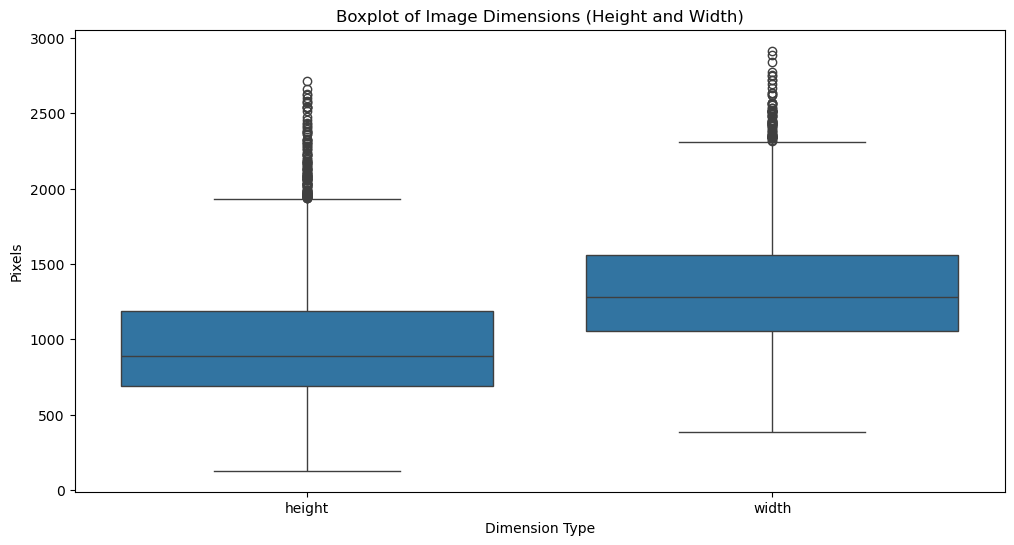

In [76]:
# Create a BoxPlot to see distribution of image dimensions

# Create the boxplot dataframe for Seaborn
df_plot = pd.melt(df, value_vars=['height', 'width'], var_name='Dimension Type', value_name='Pixels')

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dimension Type', y='Pixels', data=df_plot)

# Add title and labels
plt.title("Boxplot of Image Dimensions (Height and Width)")
plt.xlabel("Dimension Type")
plt.ylabel("Pixels")
plt.show()

The box plot and statistics on Height and Width show a pretty large disparity in image sizes with Minimum Height and Width of 127 and 384, and Maximum Height and Widths of 2916 and 2713. Below are two common approaches for handling image size disparities for computer vision algorithms:  
- Option 1:  *Resizing all images to a fixed dimension* - This option is useful to have a consistent image size but may result in a loss of aspect ratio.   
- Option 2: *Adaptive or Center Cropping* - This is useful when the center of the image is what matters and can be useful for object classification (assumign the object is in the cropped image)

Below explores these options in more detail.

In [96]:
def compare_transformed_imgs(img_list, transform):
   '''Function for applying a transformation to an image list, and displaying the Original and Transformed results.'''     
    # Create a 2x2 plot
    fig, axes = plt.subplots(nrows=2, ncols=4)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot images (alternating large and cropped)
    for i, image_path in enumerate(img_list):
        # Load image using PIL (to maintain compatibility with torchvision)
        image = Image.open(image_path)
    
        # Convert to grayscale and apply transformation (center crop)
        cropped_img = transform(image)
        
        # Convert cropped image back to NumPy for visualization
        cropped_img = cropped_img.squeeze(0).numpy()  # Remove channel dimension
    
        # Display large image (even index)
        axes[2 * i].imshow(image.convert("L"), cmap="gray")
        axes[2 * i].set_title("Original Image")
    
        # Display cropped image (odd index)
        axes[2 * i + 1].imshow(cropped_img, cmap="gray")
        axes[2 * i + 1].set_title("Transformed Image")
    
    # Remove axes borders
    for ax in axes:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    

### Option 1: Resize Images

In [106]:
# Get Random sample of Large Images
large_images = df[(df['width'] > 2500) & (df['height'] > 2000)]['image_path'].sample(n=4)

# Get Random sample of Small Images
small_images =  df[(df['width'] < 900) & (df['height'] < 600)]['image_path'].sample(n=4)

# resize to fixed image size of 960 x 1280
resize_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((960, 1280)),  
    transforms.ToTensor()
])

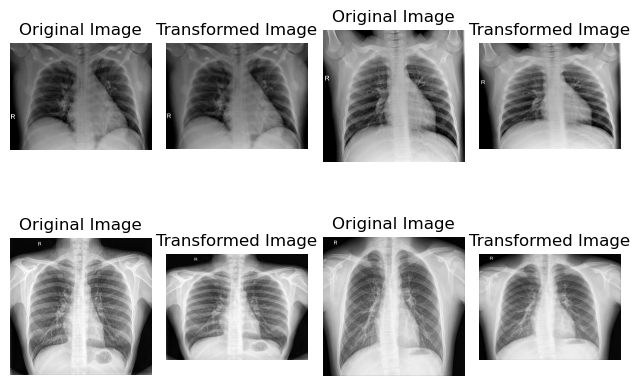

In [108]:
# Resize of Large Images based on Averages
compare_transformed_imgs(large_images, resize_transform)

There is not much noticable differences in the main part of the images across the Original and Resized.  There is some distortion with the chest cavity being slightly more compact with the transformed image, but it is fully displayed.

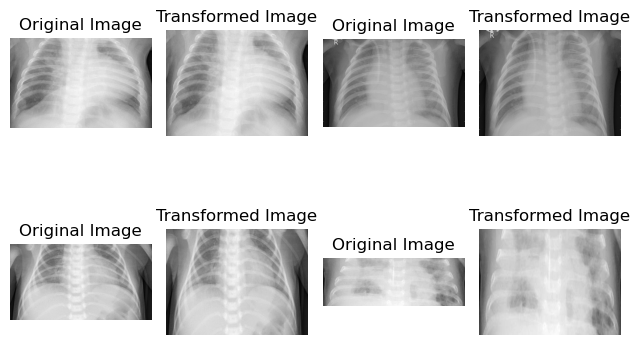

In [109]:
# Resize of Small Images based on Averages
compare_transformed_imgs(small_images, resize_transform)

Again we see some slight distortion when comparing the original to the transformed image, but this time the chest cavity is elongated.  The chest cavity is still fully represented in the original and transformed images.

### Option 2: Center Crop

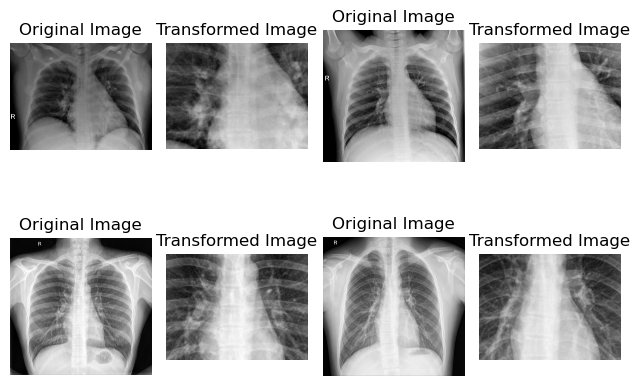

In [110]:
# Define a center crop transformation of size 960 x 1280
crop_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.CenterCrop((960, 1280)), 
    transforms.ToTensor() 
])

# Center Crop of Large Images based on Averages
compare_transformed_imgs(large_images, crop_transform)

These images are pretty zoomed in, and don't show much of the chest cavity.  This is not an ideal representation of the x-ray image.

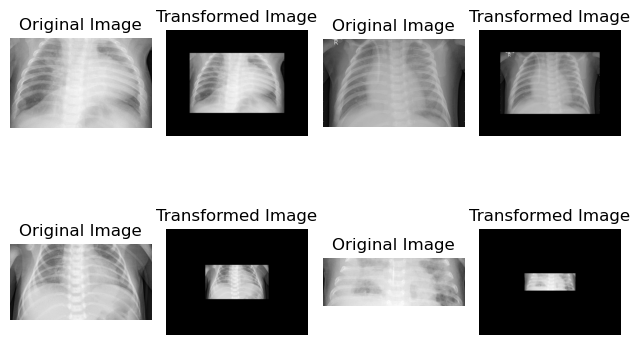

In [111]:
# Center Crop of Small Images based on Averages
compare_transformed_imgs(small_images, crop_transform)

These imaegs are extremely compressed with a lot of black border to fill the larger image size.  These are not ideal representations of the X-ray images.

**Conclusion:**  Due to the large disparity between the Small image sizes and Large image sizes, working with the resized images seems preferrable as the full chest cavity is still easily detected for processing by the ML model.  If there was less variety in image size then maybe the cropped images would be more usable.  This resize will need to be done as part of the preprocess of data when feeding the images to the ML model.


## Analyze Pixel Intensity

Outliers in Normal category: [  62   64   82  308  374  595  604  753  754  837  838  852  917  953
  956  963 1078 1254 1357 1462 1468 1476 1482 1486 1488 1501 1545] (Lower: 88.26, Upper: 156.36)
Outliers in Pneumonia category: [ 201  504  635  814  835  836  857  858  868  880  886  888  918 1118
 1199 1425 1589 1792 1945 1946 1980 2065 2069 2072 2119 2513 2710 2718
 2935 3012 3071 3256 3476 3510 3645 3659 3671 3754 3813 4020 4219] (Lower: 71.89, Upper: 174.53)


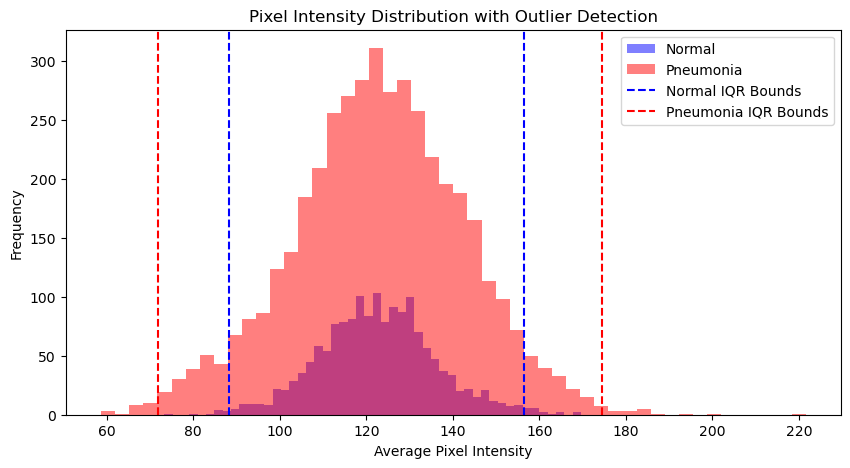

In [117]:

def compute_avg_intensity(image_paths):
    ''' Function that computes the average pixel intensity of each image'''
    intensities = []

    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Compute mean pixel intensity and append to list
            avg_intensity = np.mean(img)
            intensities.append(avg_intensity)
    
    return np.array(intensities)

# Compute average pixel intensity for each image
normal_intensities = compute_avg_intensity(normal_imgs)
pneumonia_intensities = compute_avg_intensity(pneumonia_imgs)

# Function to detect outliers using IQR method
def detect_outliers_iqr(intensities):
    Q1 = np.percentile(intensities, 25)
    Q3 = np.percentile(intensities, 75)
    # Interquartile range
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR

    outliers = (intensities < lower_bound) | (intensities > upper_bound)

    # Returns indices of outliers and the lower/uppor bounds
    return np.where(outliers)[0], lower_bound, upper_bound

# Detect outliers in both categories
outliers_normal, lower_n, upper_n = detect_outliers_iqr(normal_intensities)
outliers_pneumonia, lower_p, upper_p = detect_outliers_iqr(pneumonia_intensities)

# Print Outlier indexes and lower/upper bounds
print(f"Outliers in Normal category: {outliers_normal} (Lower: {lower_n:.2f}, Upper: {upper_n:.2f})")
print(f"Outliers in Pneumonia category: {outliers_pneumonia} (Lower: {lower_p:.2f}, Upper: {upper_p:.2f})")

# Plot the intensity distributions and ranges
plt.figure(figsize=(10, 5))
plt.hist(normal_intensities, bins=50, alpha=0.5, label="Normal", color="blue")
plt.hist(pneumonia_intensities, bins=50, alpha=0.5, label="Pneumonia", color="red")

plt.axvline(lower_n, color="blue", linestyle="--", label="Normal IQR Bounds")
plt.axvline(upper_n, color="blue", linestyle="--")
plt.axvline(lower_p, color="red", linestyle="--", label="Pneumonia IQR Bounds")
plt.axvline(upper_p, color="red", linestyle="--")

plt.xlabel("Average Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution with Outlier Detection")
plt.legend()
plt.show()


Interestingly the average pixel intensity of Pneumonia images are higher than Normal images.  This may be a key feature the ML model picks up on when processing the images.  Let's visualize some of these images to see what the dark and bright images look like in each category.

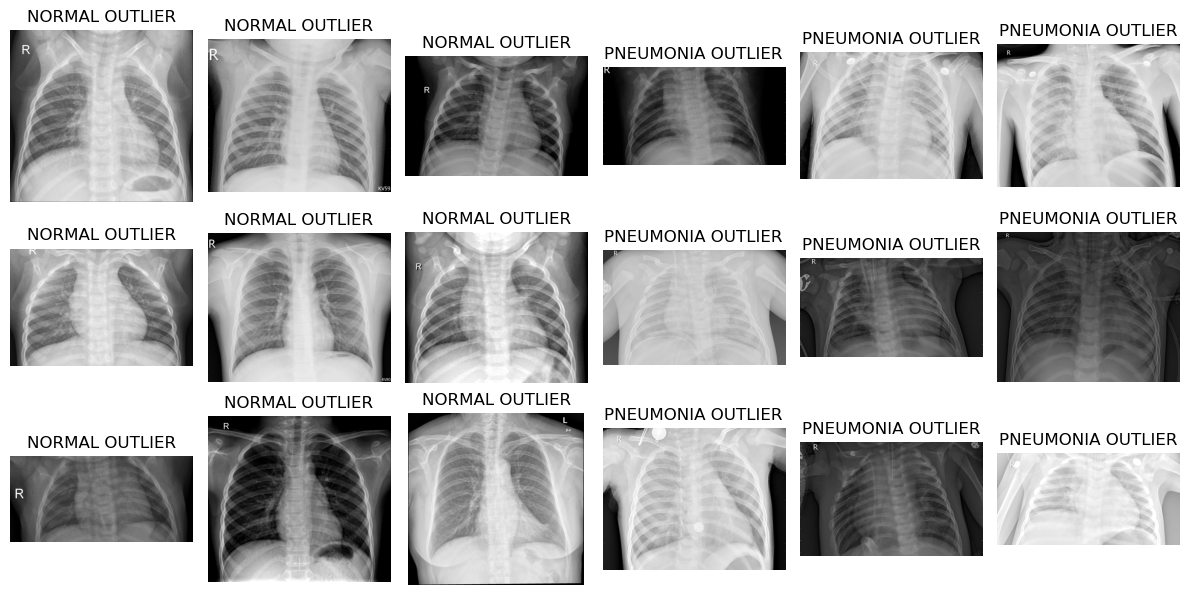

In [129]:
# Get outlier file paths corresponding to the indices
sample_norm_outliers = random.sample(normal_imgs.iloc[outliers_normal].tolist(), 9)
sample_pneum_outliers = random.sample(pneumonia_imgs.iloc[outliers_pneumonia].tolist(), 9)

# Visualize some of the outliers
compare_imgs(pd.Series(sample_norm_outliers), pd.Series(sample_pneum_outliers), "NORMAL OUTLIER", "PNEUMONIA OUTLIER")

Some of these images look overly saturated or perhaps too ark to clearly see strutures.  A model trained on a wide variety of image intenseties will help it learn and generalize better.  However, there may be upper or lower bounds of usefulness.  This is something we should watch for in a classifying ML model. These overly bright or dark images may have difficulties in classification. 

## Image Visualization Techniques

In [165]:

def plot_img_visualizations(img_array_1, img_array_2, label_1, label_2):
    '''Function to Compare 2 sets of images that have already been loaded and visualized with various techniques'''
    # Create a 2x4 plot
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
    
    # Plot images
    for i in range(4):
        # Load images
        img_1 = img_array_1[i]
        img_2 = img_array_2[i]
        
        # Images (First 2columns)
        axes[i // 2, i % 2].imshow(img_1)
        axes[i // 2, i % 2].set_title(label_1)
    
        # Images (Next 2 columns)
        axes[i // 2, i % 2 + 2].imshow(img_2)
        axes[i // 2, i % 2 + 2].set_title(label_2)
    
    # Remove axes
    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()



# Select a sample of NORMAL and PNEUMONIA images for use in Visualizations 
sample_size = 4
normal_sample = df[df['label'] == 'NORMAL']['image_path'].sample(n=sample_size)
pneumonia_sample =  df[df['label'] == 'PNEUMONIA']['image_path'].sample(n=sample_size)

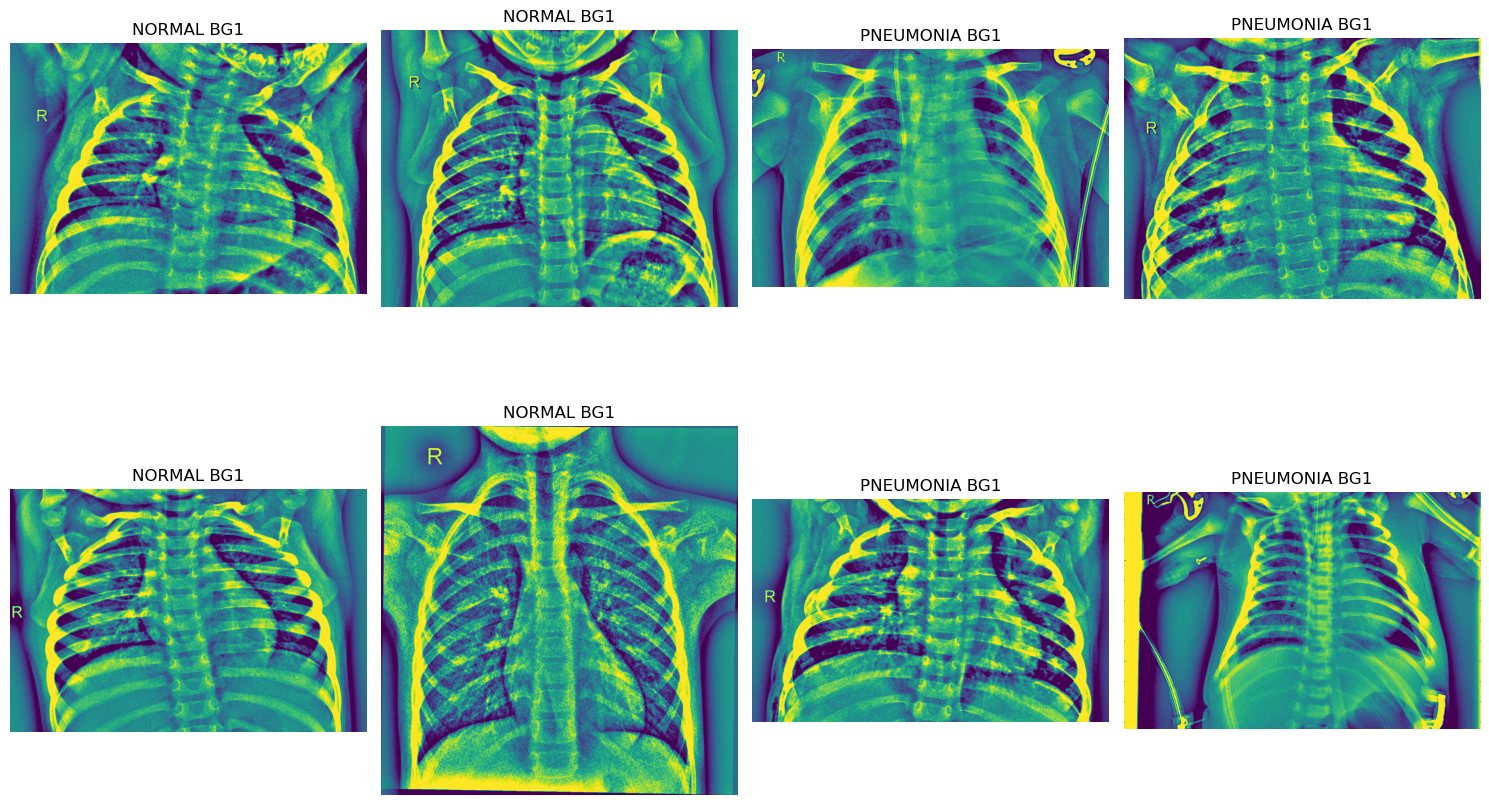

In [184]:
# Ben Graham's Method - Option 1
def bg_method_1(img_path):
    # Load the grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    return img

# Creaet Arrays to hold imaegs
bg_normal_1 = []
bg_pneum_1 = []

# Process Normal images using Ben Graham Method 1
for i in range(len(normal_sample)):
    new_img = bg_method_1(normal_sample.iloc[i])
    bg_normal_1.append(new_img)
    
# Process Pneumonia images using Ben Graham Method 1
for i in range(len(pneumonia_sample)):
    new_img = bg_method_1(pneumonia_sample.iloc[i])
    bg_pneum_1.append(new_img)

# Output visualization of NORMAL and Pneumonia images
plot_img_visualizations(bg_normal_1, bg_pneum_1, "NORMAL BG1", "PNEUMONIA BG1")

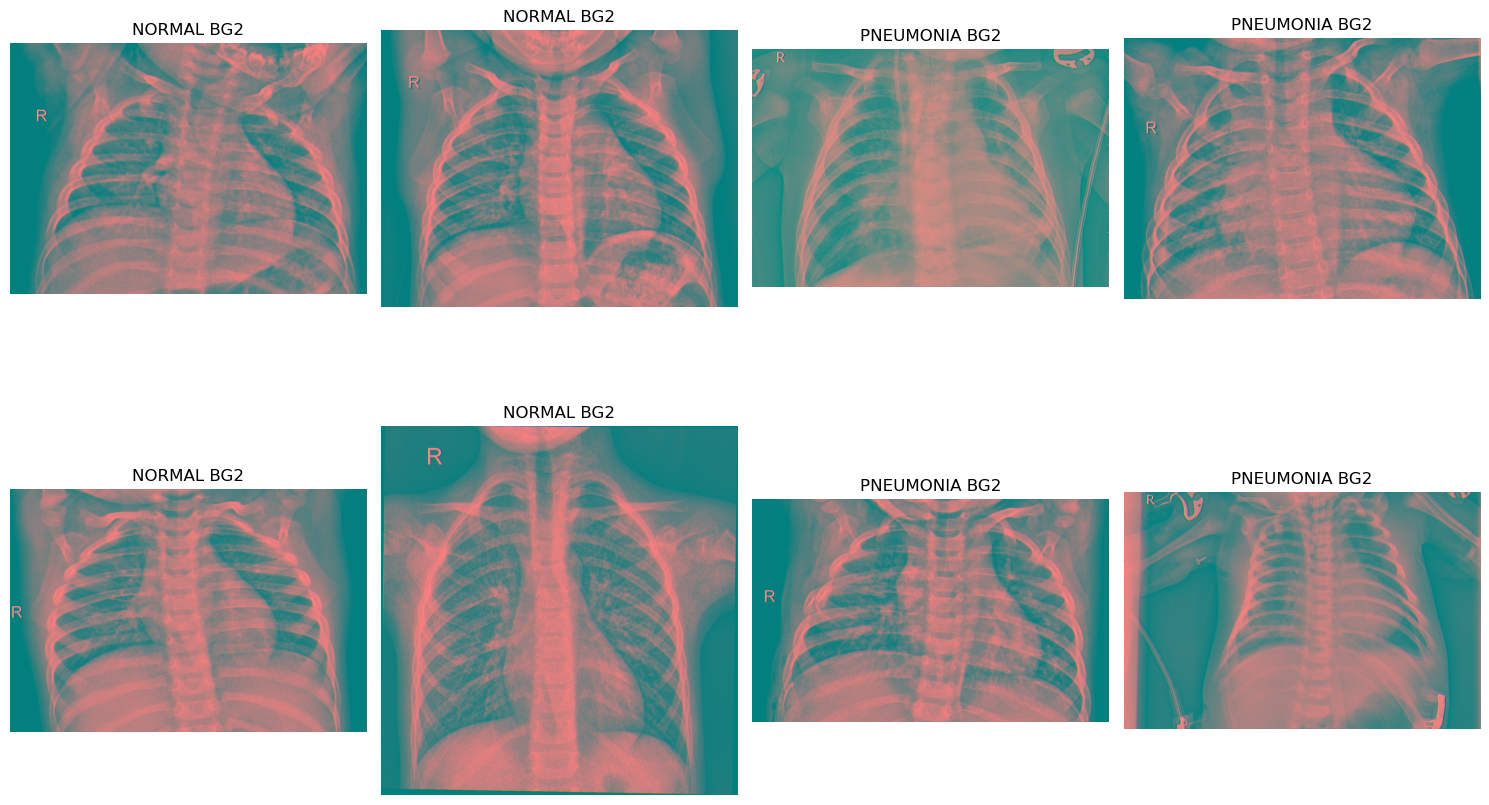

In [171]:
# Ben Graham's Method - Option 2
def bg_method_2(img_path):
    # Load the grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply contrast limited adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    # Apply Sobel filters to detect edges in x and y directions
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Normalize Sobel responses
    sobelx = cv2.normalize(sobelx, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    sobely = cv2.normalize(sobely, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Stack images into a pseudo-RGB image
    img_pseudo_rgb = cv2.merge([img_clahe, sobelx, sobely])

    return img_pseudo_rgb

# Creaet Arrays to hold imaegs
bg_normal_2 = []
bg_pneum_2 = []

# Process Normal images using Ben Graham Method 1
for i in range(len(normal_sample)):
    new_img = bg_method_2(normal_sample.iloc[i])
    bg_normal_2.append(new_img)
    
# Process Pneumonia images using Ben Graham Method 1
for i in range(len(pneumonia_sample)):
    new_img = bg_method_2(pneumonia_sample.iloc[i])
    bg_pneum_2.append(new_img)

# Output visualization of NORMAL and Pneumonia images
plot_img_visualizations(bg_normal_2, bg_pneum_2, "NORMAL BG2", "PNEUMONIA BG2")

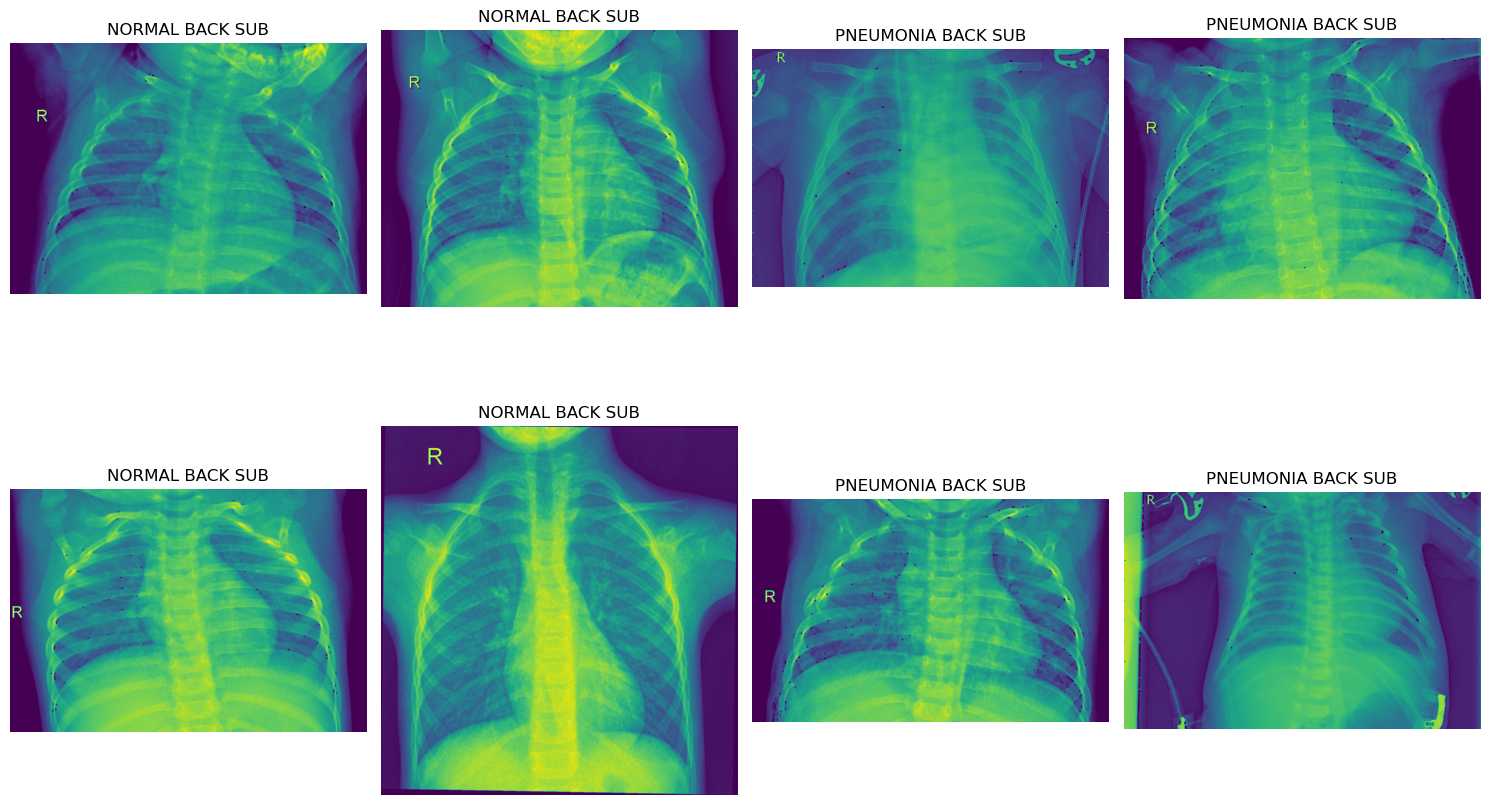

In [176]:
# Background Subraction
def background_subtraction(img_path):
    """Removes background using adaptive thresholding."""
    
    # Load grayscale X-ray image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply Adaptive Thresholding
    mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Refine mask with morphological operations
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Apply mask
    result = cv2.bitwise_and(img, img, mask=mask)

    return result


# Creaet Arrays to hold imaegs
bg_sub_normal = []
bg_sub_pneum = []

# Process Normal images using Ben Graham Method 1
for i in range(len(normal_sample)):
    new_img = background_subtraction(normal_sample.iloc[i])
    bg_sub_normal.append(new_img)
    
# Process Pneumonia images using Ben Graham Method 1
for i in range(len(pneumonia_sample)):
    new_img = background_subtraction(pneumonia_sample.iloc[i])
    bg_sub_pneum.append(new_img)

# Output visualization of NORMAL and Pneumonia images
plot_img_visualizations(bg_sub_normal, bg_sub_pneum, "NORMAL BACK SUB", "PNEUMONIA BACK SUB")

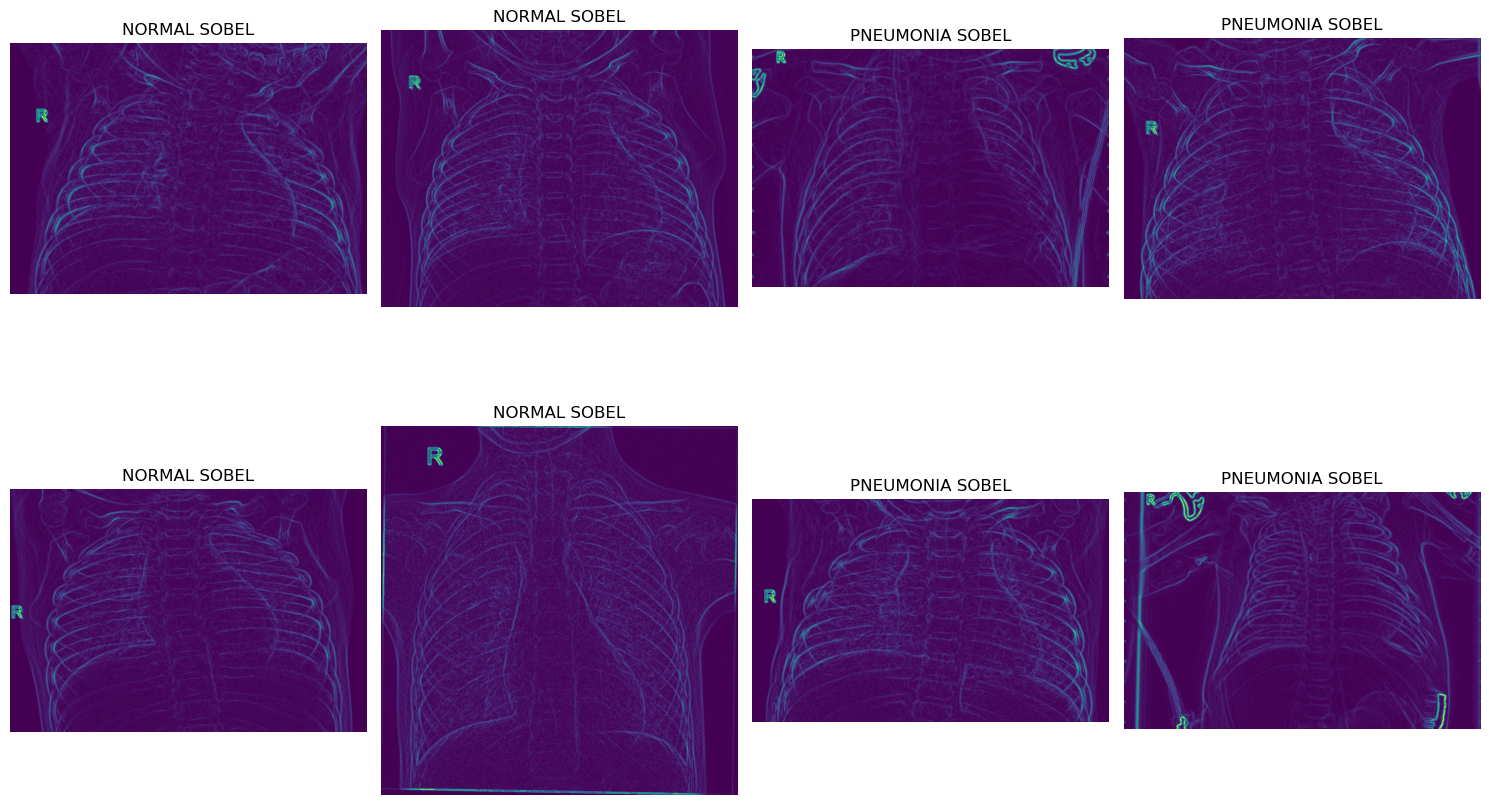

In [186]:

def sobel_method(img_path):
    '''Apply the Sobel Method to an Image for Edge Detection'''
    # Load the grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Apply Gaussian Blur to reduce noise and smooth the image
    img = cv2.GaussianBlur(img, (11, 11), 0)
    # Apply Sobel operator in the X direction
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobel_x = np.uint8(np.absolute(sobel_x))
    # Apply Sobel operator in the Y direction
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_y = np.uint8(np.absolute(sobel_y))

    # Combine the X and Y edges and return image
    img_edges = cv2.bitwise_or(sobel_x, sobel_y)
    return img_edges


# Creaet Arrays to hold imaegs
bg_sobel_normal = []
bg_sobel_pneum = []

# Process Normal images using Ben Graham Method 1
for i in range(len(normal_sample)):
    new_img = sobel_method(normal_sample.iloc[i])
    bg_sobel_normal.append(new_img)
    
# Process Pneumonia images using Ben Graham Method 1
for i in range(len(pneumonia_sample)):
    new_img = sobel_method(pneumonia_sample.iloc[i])
    bg_sobel_pneum.append(new_img)

# Output visualization of NORMAL and Pneumonia images
plot_img_visualizations(bg_sobel_normal, bg_sobel_pneum, "NORMAL SOBEL", "PNEUMONIA SOBEL")

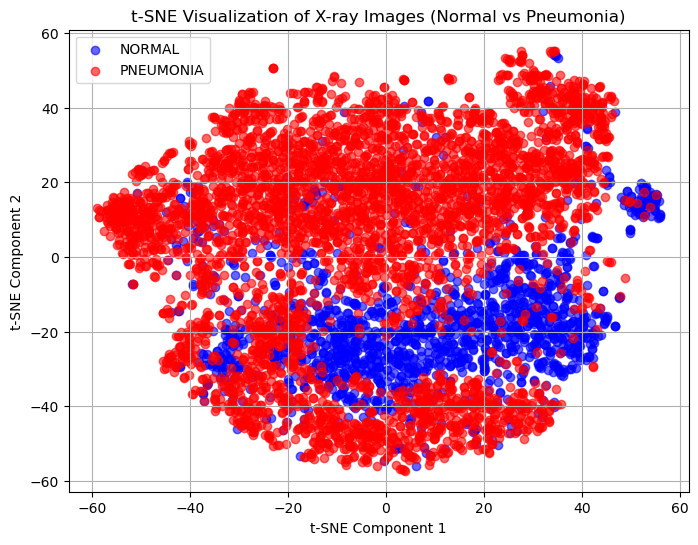

In [188]:

def load_and_preprocess_images(image_paths, target_size=(64, 64)):
    """Loads images, resizes them, and flattens them into a vector."""
    images = []
    
    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize to fixed dimensions
            img = img.flatten()  # Flatten to 1D vector
            images.append(img)
    
    return np.array(images)

# Load and preprocess images
normal_images = load_and_preprocess_images(normal_imgs)
pneumonia_images = load_and_preprocess_images(pneumonia_imgs)

# Create labels (0 = NORMAL, 1 = PNEUMONIA)
labels_normal = np.zeros(len(normal_images))
labels_pneumonia = np.ones(len(pneumonia_images))

# Combine datasets
X = np.vstack((normal_images, pneumonia_images))  # Image feature vectors
y = np.concatenate((labels_normal, labels_pneumonia))  # Labels

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], label='NORMAL', alpha=0.6, color='blue')
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='PNEUMONIA', alpha=0.6, color='red')

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of X-ray Images (Normal vs Pneumonia)")
plt.legend()
plt.grid(True)
plt.show()


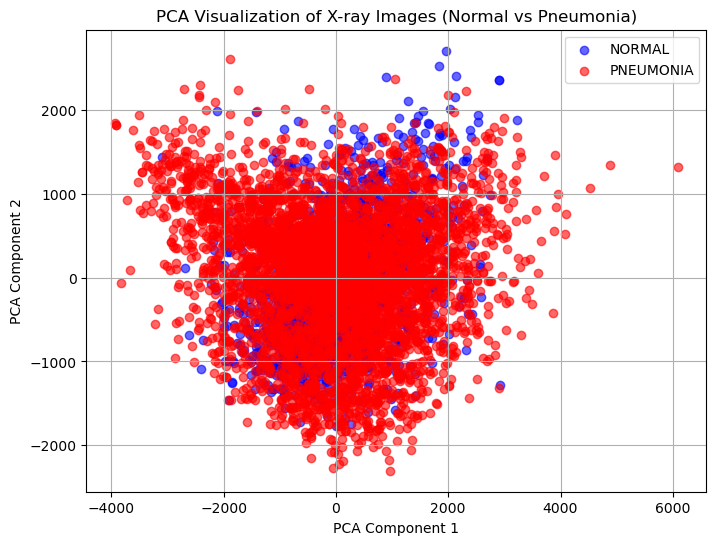

In [189]:


# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='NORMAL', alpha=0.6, color='blue')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='PNEUMONIA', alpha=0.6, color='red')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of X-ray Images (Normal vs Pneumonia)")
plt.legend()
plt.grid(True)
plt.show()
